In [1]:
from io import StringIO
import pandas as pd
import numpy as np

Reading the JSON:

In [284]:
json_array = "["
with open("raw/webis_news_bias_20.json") as f:
    json_array += ",".join(line for line in f)
json_array += "]"

df = pd.read_json(StringIO(json_array))
df

,source,title,event_id,adfontes_fair,adfontes_political,allsides_bias,content,misc
0,Fox News,"Trump blasts Howard Schultz, says ex-Starbucks...",0,bias,bias,From the Right,Obama administration alum Roger Fisk and Repub...,"{'time': '2019-01-28 16:10:44.680484', 'topics..."
1,USA TODAY,Trump blasts former Starbucks CEO Howard Schul...,0,bias,neutral,From the Center,WASHINGTON – President Donald Trump took a swi...,"{'time': 'None', 'topics': 'Election: Presiden..."
2,Washington Times,Mick Mulvaney: Trump to secure border 'with or...,0,bias,neutral,From the Right,Acting White House chief of staff Mick Mulvane...,"{'time': 'None', 'topics': 'White House', 'aut..."
3,Washington Times,Trump says 'we'll do the emergency' if border ...,0,bias,neutral,From the Right,President Trump repeated his vow Friday to dec...,"{'time': 'None', 'topics': 'White House, Polit..."
4,BBC News,Trump backs down to end painful shutdown tempo...,0,bias,neutral,From the Center,President Donald Trump has yielded to politica...,"{'time': '2019-01-26 00:00:00', 'topics': 'Whi..."
...,...,...,...,...,...,...,...,...
7770,Politico,Ann Romney's task: Humanize Mitt,0,bias,neutral,From the Left,"TAMPA, Fla. — Ann Romney will take to the podi...","{'time': '2012-08-28 04:59:14', 'topics': 'Ele..."
7771,Washington Times,'Mittigator' to make case for Romney,0,bias,neutral,From the Right,"She is a gracious warrior with a kind face, a ...","{'time': 'None', 'topics': 'Election: Presiden..."
7772,Fox News,Convention-bound Ryan slams Obama for presidin...,0,bias,bias,From the Right,Republican VP pick on 'Special Report'\nMaking...,"{'time': '2012-08-27 00:00:00', 'topics': 'Ele..."
7773,Politico,Ryan seeks comfort of Ron Paul fans,0,bias,neutral,From the Left,Paul Ryan said Monday he expects Ron Paul supp...,"{'time': '2012-08-27 15:52:45', 'topics': 'Ele..."


Dropping useless columns:

In [285]:
df.drop(columns=["source", "event_id", "adfontes_fair", "adfontes_political", "misc"], inplace=True)

Renaming and categorizing the leaning column:

In [286]:
df.rename(columns={"allsides_bias": "leaning"}, inplace=True)
df["leaning"] = df["leaning"].astype("category")
df["leaning"] = df["leaning"].cat.rename_categories(
    {"From the Left": "left", "From the Center": "center", "From the Right": "right"}
)

Reordering the columns:

In [287]:
df = df[["title", "content", "leaning"]].copy()
df

,title,content,leaning
0,"Trump blasts Howard Schultz, says ex-Starbucks...",Obama administration alum Roger Fisk and Repub...,right
1,Trump blasts former Starbucks CEO Howard Schul...,WASHINGTON – President Donald Trump took a swi...,center
2,Mick Mulvaney: Trump to secure border 'with or...,Acting White House chief of staff Mick Mulvane...,right
3,Trump says 'we'll do the emergency' if border ...,President Trump repeated his vow Friday to dec...,right
4,Trump backs down to end painful shutdown tempo...,President Donald Trump has yielded to politica...,center
...,...,...,...
7770,Ann Romney's task: Humanize Mitt,"TAMPA, Fla. — Ann Romney will take to the podi...",left
7771,'Mittigator' to make case for Romney,"She is a gracious warrior with a kind face, a ...",right
7772,Convention-bound Ryan slams Obama for presidin...,Republican VP pick on 'Special Report'\nMaking...,right
7773,Ryan seeks comfort of Ron Paul fans,Paul Ryan said Monday he expects Ron Paul supp...,left


Printing duplicates:

In [288]:
df[df["content"].duplicated(keep=False)]

,title,content,leaning
14,Trump delays State of the Union Address until ...,WASHINGTON (Reuters) - U.S. President Donald T...,right
15,Trump delays State of the Union Address until ...,WASHINGTON (Reuters) - U.S. President Donald T...,center
133,Pelosi: ‘Open Discussion’ Whether Trump Can Be...,"Representative Nancy Pelosi (D., Calif.), who ...",right
134,Pelosi: ‘Open Discussion’ Whether Trump Can Be...,"Representative Nancy Pelosi (D., Calif.), who ...",left
197,"James Mattis quitting as defense secretary, ci...","Defense Secretary James Mattis, the last of a ...",right
...,...,...,...
7538,Last jobs report before election shows economy...,"Oct. 25, 2012: A sign attracts job-seekers dur...",right
7628,Romney Dominates In First Debate,"Who was that man, and what has he done with Mi...",right
7632,Romney Dominates In First Debate,"Who was that man, and what has he done with Mi...",right
7677,"'Fast and Furious' report slaps 14 at Justice,...",More than a dozen Justice Department and Burea...,left


Dropping the duplicates:

In [289]:
df.drop_duplicates(subset="content", inplace=True)

Inspecting content length:

In [290]:
df["content_length"] = df["content"].str.len()
df["content_word_count"] = df["content"].str.split().str.len()
df.sort_values(by="content_length", ascending=False).head()

,title,content,leaning,content_length,content_word_count
5311,"Zephyr Teachout, Hands Up United and John Oliv...",You will receive occasional promotional offers...,left,439509,69312
3327,The Perfect Weapon: How Russian Cyberpower Inv...,WASHINGTON — When Special Agent Adrian Hawkins...,left,46681,7627
4385,Obama’s State of the Union wins and losses,"For six consecutive years, President Barack Ob...",left,44838,7395
2807,,Former FBI director James Comey’s testimony in...,center,43326,7116
881,"David Hogg, After Parkland","At 2:30 on February 14, David Hogg was not yet...",left,40913,7155


In [291]:
df.sort_values(by="content_length").head()

,title,content,leaning,content_length,content_word_count
4841,State Dept. spokeswoman sparks Twitter war wit...,(CNN),left,5,1
4890,President Obama Is Fired Up and Ready to Tweet,"— President Obama (@POTUS) May 18, 2015",left,39,7
4748,Donald Trump is showing a side of the GOP that...,Like this video? Subscribe to Vox on YouTube.\...,left,105,19
1957,Incredible New Year's Celebrations Around The ...,"From the London Eye to Athens’ Acropolis, here...",left,134,22
2553,Senate blocks Trump from making recess appoint...,The Senate blocked President Trump from being ...,center,144,22


Calculating the bounds for content length:

In [292]:
q1 = np.percentile(df["content_length"], 25)
q3 = np.percentile(df["content_length"], 75)
iqr = q3 - q1
lower_bound_multiplier = 0.5
upper_bound_multiplier = 9
lower_bound = q1 - lower_bound_multiplier * iqr
upper_bound = q3 + upper_bound_multiplier * iqr
lower_bound, upper_bound

(np.float64(887.5), np.float64(40005.25))

Removing the outliers based on the content length:

<Axes: >

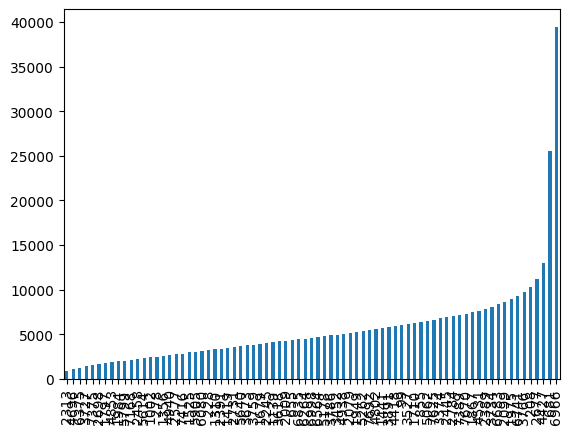

In [293]:
df = df[(df["content_length"] >= lower_bound) & (df["content_length"] <= upper_bound)]
content_length = df["content_length"].sort_values()
# Ensuring to include the last (longest) item.
downsampled = pd.concat([content_length.iloc[::100], content_length.iloc[[-1]]]).drop_duplicates()
downsampled.plot.bar()

The leaning distribution:

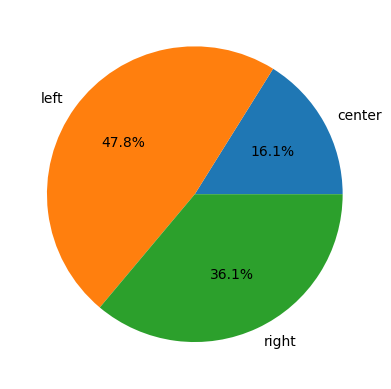

In [294]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

In [295]:
df.to_csv("preprocessed/webis_news_bias_20.csv")

In [302]:
mean_value = df["content_length"].mean()

# Find the row where the value is closest to the mean
closest_row = df.iloc[(df["content_length"] - mean_value).abs().idxmin()]

closest_row


title                 Obama warns disabled veterans prolonged seques...
content               Saturday, Aug.10, 2013: President Obama speaks...
leaning                                                           right
content_length                                                     3568
content_word_count                                                  571
Name: 6625, dtype: object